In [1]:
# Created 6/11/19
# Last updated on 7/25/19
# File is on both the AC922 and DGX

# Cell 1

print('\nBegin Part 1 of 6 - Imports\n')

import time
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.plotting import autocorrelation_plot
from sklearn.metrics import mean_squared_error
import statistics
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller


total_run_time_start_time = dt.datetime.now()
print('Start time: ' + str(total_run_time_start_time))

print('\nFinished Part 1 of 6 - Imports.  Ready to move to next cell.')
print(np.__version__)
print(pd.__version__)



Begin Part 1 of 6 - Imports

Start time: 2019-07-31 16:37:00.379065

Finished Part 1 of 6 - Imports.  Ready to move to next cell.
1.14.5
0.24.2


In [2]:
# Cell 2

# Set initial variables
print('\nBegin Part 2 of 6 - Set variables\n')

# Set initial_path
initial_path = '/home/pace/glucose/data_files/adolescent-2160-0-Dexcom-Cozmo-Basal/'

# Set file name prefix
input_train_file_name_prefix = 'adolescent#001'
input_test_file_name_prefix = 'adolescent#001'

# Set processed_train_file_name and processed_test_file_name
processed_train_file_name = input_train_file_name_prefix + '-train-processed.csv'
processed_test_file_name = input_test_file_name_prefix + '-test-processed.csv'

# Determine if data should be plotted
plot_data = 'Y' # Values are Y or N
# Determine if stepwise ARIMA should be run to find p,d,q - code is in the last cell
stepwise = 'N' # Values are Y or N

# Set SARIMAX parameters
pdq = (4, 0, 3) #p,d,q
PDQm = (1, 1, 1, 7) #P,D,Q,m

print('\nFinished Part 2 of 6 - Set variables.  Ready to move to next cell.')


Begin Part 2 of 6 - Set variables


Finished Part 2 of 6 - Set variables.  Ready to move to next cell.


In [3]:
# Cell 3

# Read the processed files into dfs and group by date

print('\nBegin Part 3 of 6 - Read processed file and group by date\n')

train_df = pd.read_csv(str(initial_path + processed_train_file_name), index_col=False)
test_df = pd.read_csv(str(initial_path + processed_test_file_name), index_col=False)

train_df.drop(['Time'], axis=1, inplace=True)
test_df.drop(['Time'], axis=1, inplace=True)

# Add leading zeros to Hour otherwise it displays in the wrong order
# 0, 1, 10, etc
train_df['Hour']=train_df['Hour'].apply(lambda x: '{0:0>2}'.format(x))
test_df['Hour']=test_df['Hour'].apply(lambda x: '{0:0>2}'.format(x))

# Combine Date and Hour into Date_Hour so it can be used as a series later
train_df['Date_Hour'] = train_df.Date.astype(str).str.cat(train_df.Hour.astype(str), sep=':')
test_df['Date_Hour'] = test_df.Date.astype(str).str.cat(test_df.Hour.astype(str), sep=':')

# Drop Date and Hour since they are no longer needed
train_df.drop(['Date', 'Hour'], axis=1, inplace=True)
test_df.drop(['Date', 'Hour'], axis=1, inplace=True)

# Group BG levels by Date_Hour in both dfs.
train_grouped_df = train_df.groupby('Date_Hour', as_index=False)[['BG']].mean()
test_grouped_df = test_df.groupby('Date_Hour', as_index=False)[['BG']].mean()

print('\nFinished Part 3 of 6 - Read processed file and group by date.  Ready to move to next cell.')


Begin Part 3 of 6 - Read processed file and group by date


Finished Part 3 of 6 - Read processed file and group by date.  Ready to move to next cell.



Begin Part 4 of 6 - Plot train and test data



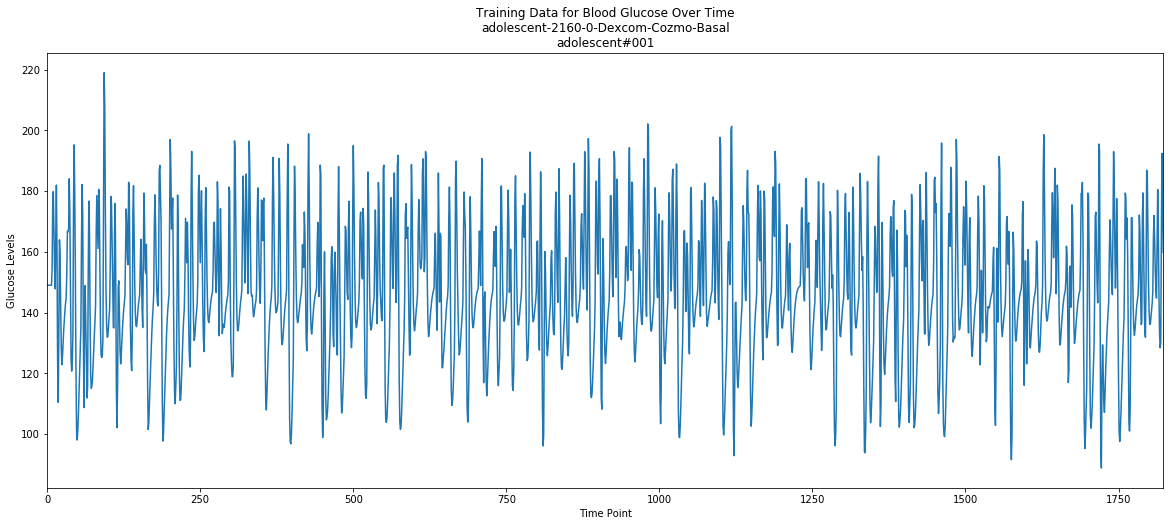

Beginning value for training data:
2019-05-01:00 0    149.020011
Name: BG, dtype: float64

Number of training data points: 1824


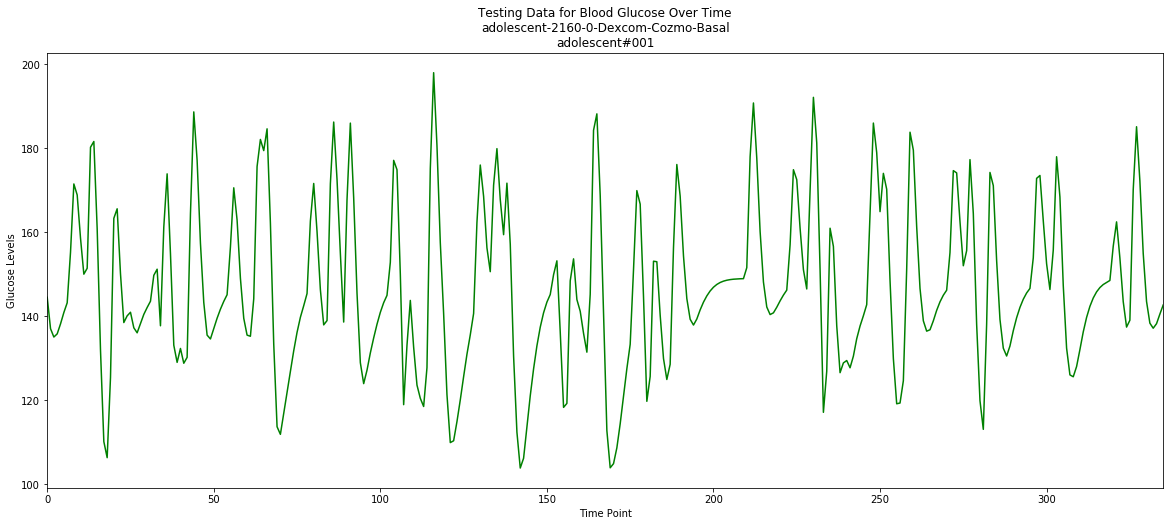

Beginning value for testing data:
2019-07-16:00 0    144.555197
Name: BG, dtype: float64

Number of testing data points: 336

Finished Part 4 of 6 - Plot train and test data.  Ready to move to next cell.


In [4]:
# Cell 4

# Plot test and train data
print('\nBegin Part 4 of 6 - Plot train and test data\n')

# Plot means
if(plot_data == 'Y'):
    
  #Plot the training data
  # Convert column BG to a series so it can be plotted
  train_grouped_series = train_grouped_df['BG']
  plt.figure(figsize=(20,8))
  train_grouped_series.plot('line', title='Training Data for Blood Glucose Over Time\nadolescent-2160-0-Dexcom-Cozmo-Basal\n' + 
                       input_train_file_name_prefix)

  plt.xlabel('Time Point')  
  plt.ylabel('Glucose Levels')
  plt.show()

  print('Beginning value for training data:')
  print(str(train_grouped_df.iloc[0,0]) + ' ' + str(train_grouped_series[[0]]))
  print('\nNumber of training data points: ' + str(len(train_grouped_series)))


  # Plot the testing data
  # Convert column BG to a series so it can be plotted
  test_grouped_series = test_grouped_df['BG']
  plt.figure(figsize=(20,8))
  test_grouped_series.plot('line', color='green', title='Testing Data for Blood Glucose Over Time\nadolescent-2160-0-Dexcom-Cozmo-Basal\n' + 
                       input_test_file_name_prefix)
  
  plt.xlabel('Time Point')  
  plt.ylabel('Glucose Levels')
  plt.show()

  print('Beginning value for testing data:')
  print(str(test_grouped_df.iloc[0,0]) + ' ' + str(test_grouped_series[[0]]))
  print('\nNumber of testing data points: ' + str(len(test_grouped_series)))

print('\nFinished Part 4 of 6 - Plot train and test data.  Ready to move to next cell.')

In [5]:
# Cell 5

# Run Augmented Dickey-Fuller test to check for stationarity
# Null hypothesis is that data is not stationary, so p < 0.05 indicates stationarity
# and we do not need the differencing parameter (d) changed from 0 in the ARIMA model
result = adfuller(train_grouped_series)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
  print('\t%s: %.3f' % (key, value))



ADF Statistic: -7.036249
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


/home/pace/anaconda3/envs/pace/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/pace/anaconda3/envs/pace/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/pace/anaconda3/envs/pace/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


Time point = 1825 - Predicted value = 142.413, Expected value = 144.555 
Time point = 1845 - Predicted value = 180.197, Expected value = 163.364 
Time point = 1865 - Predicted value = 135.712, Expected value = 132.370 
Time point = 1885 - Predicted value = 141.292, Expected value = 135.542 
Time point = 1905 - Predicted value = 163.700, Expected value = 171.657 
Time point = 1925 - Predicted value = 143.894, Expected value = 140.971 
Time point = 1945 - Predicted value = 118.874, Expected value = 121.382 
Time point = 1965 - Predicted value = 121.281, Expected value = 130.584 
Time point = 1985 - Predicted value = 142.412, Expected value = 141.234 
Time point = 2005 - Predicted value = 117.875, Expected value = 119.783 
Time point = 2025 - Predicted value = 146.661, Expected value = 146.952 
Time point = 2045 - Predicted value = 142.429, Expected value = 143.704 
Time point = 2065 - Predicted value = 133.750, Expected value = 129.496 
Time point = 2085 - Predicted value = 157.307, Expe

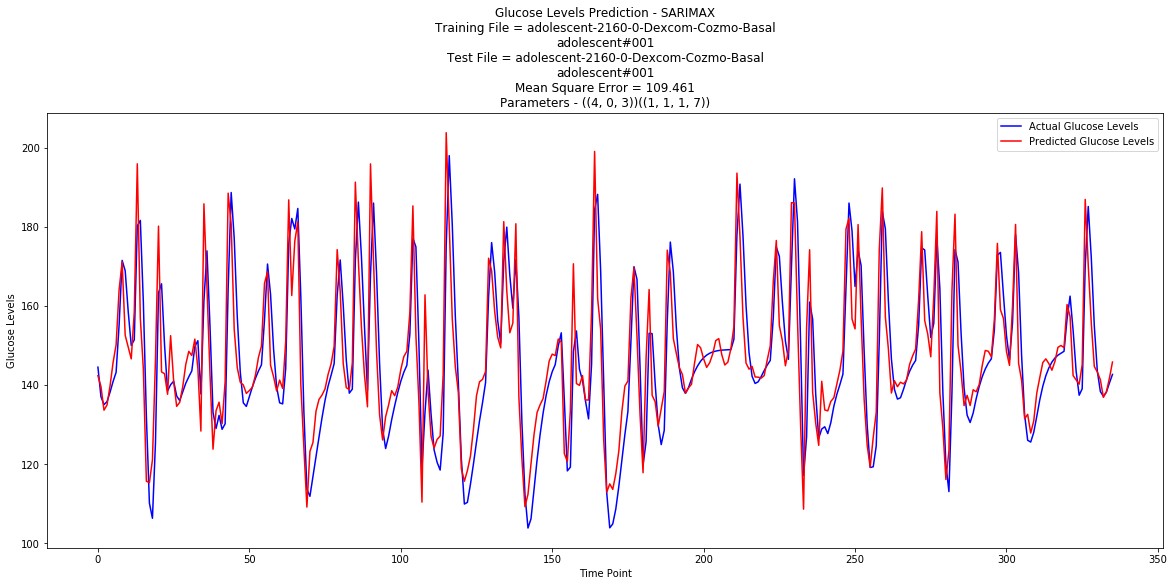

Finished Part 6 of 6 - Plotting.  Script finished.



In [6]:
# Cell 6

# Get start time for training and predictions
train_predict_start_time = dt.datetime.now()

# Concatenate the 2 series in order to get one 
combined_series = pd.concat([train_grouped_series, test_grouped_series])

# Set train and test sections of input series
train, test = combined_series[0:len(train_grouped_series)], combined_series[len(train_grouped_series):len(combined_series)]

# Define model based on training data
train_model = sm.tsa.SARIMAX(combined_series[:1824], order=pdq, seasonal_order=PDQm)
# Fit the model
train_model_fit = train_model.fit()

# Make a new model for the test data that has the values from the training model 
train_model = sm.tsa.SARIMAX(combined_series, order=pdq, seasonal_order=PDQm)
# Fit the model
test_model_fit = train_model.filter(train_model_fit.params)

# Run the predictions (1825 is the beginning of the test records)
predict_test = test_model_fit.get_prediction(start=1825, end=2160, dynamic=False, full_results=True)
predict_test = predict_test.predicted_mean

# Predictions is used to hold the predicted values
predictions = []

# Loop through each value in the test data and check it against the prediction
for i in range(1825,2161):
  predictions.append(predict_test.get(i))
  if((i - 1825) % 20 == 0):
    print('Time point = ' + str(i) + ' - Predicted value = %.3f, Expected value = %.3f ' % 
          (predict_test.get(i), test[i - 1825]))

# Calculate the MSE and print
mean_square = mean_squared_error(test, predictions)
print('\nTest MSE: %.3f' % mean_square)

# Get end time for training and predictions
train_predict_end_time = dt.datetime.now()

# Calculate total training time
train_predict_total_time = (train_predict_end_time-train_predict_start_time).total_seconds()

print('\n\nTotal train and predict time %.1f' % train_predict_total_time)

# Plot the predictions

print('\nBegin Part 6 of 6 - Plotting\n')

plt.figure(figsize=(20,8))
plt.plot(test, color='blue', label='Actual Glucose Levels')
plt.plot(predictions, color='red', label='Predicted Glucose Levels')
plt.title('Glucose Levels Prediction - SARIMAX\nTraining File = adolescent-2160-0-Dexcom-Cozmo-Basal\n' 
          + input_train_file_name_prefix
          + '\nTest File = adolescent-2160-0-Dexcom-Cozmo-Basal\n' + input_test_file_name_prefix + 
          str('\nMean Square Error = %.3f' % mean_square) +
         '\nParameters - (' + str(pdq) + ')(' + str(PDQm) + ')')  
plt.xlabel('Time Point')  
plt.ylabel('Glucose Levels')  
plt.legend()  
plt.show()

print('Finished Part 6 of 6 - Plotting.  Script finished.\n')


In [7]:
# Cell 7

total_run_time_end_time = dt.datetime.now()

print(str('\nMean Square Error = %.3f' % mean_square))

print('\n\nTotal train and predict time %.1f' % train_predict_total_time)

print('\n\nTotal run time %.1f' % (total_run_time_end_time-total_run_time_start_time).total_seconds() + ' seconds.')




Mean Square Error = 109.461


Total train and predict time 21.8


Total run time 23.0 seconds.


In [8]:
# Cell 8

# This cell is only run if stepwise ARIMA needs to be run to determine hyperparameters
# pdq and PDQm

if (stepwise == 'Y'):

  # Fitting a stepwise model:
  from pmdarima.arima import auto_arima

  # Data should be stationary by this point, thus d=0
  # The value of D is determined in cell above
  stepwise_fit = auto_arima(train_grouped_series, start_p=1, start_q=1, max_p=5, max_q=5, m=7,
                            d=0, start_P=0, seasonal=True, D=1, trace=True,
                            error_action='ignore',  # don't want to know if an order does not work
                            suppress_warnings=True,  # don't want convergence warnings
                            stepwise=True)  # set to stepwise

  stepwise_fit.summary()